# `MeshArrays.jl` defines the `MeshArray` type

Each `MeshArray` contains an array of elementary arrays that (1) are connected at their edges and (2) collectively form a global grid. Overall grid specifications are contained within `gcmgrid` instances, which merely define array sizes and how e.g. grid variables are represented in memory. Importantly, it is only when e.g. grid variables are read from file that sizable memory is allocated.

## Initialize Framework

1. import `MeshArrays` and plotting tools
2. choose e.g. a standard `MITgcm` grid
3. download the grid if needed


In [1]:
using MeshArrays, Plots

pth="../inputs/GRID_LLC90/"
γ=GridSpec("LatLonCap",pth)

http="https://github.com/gaelforget/GRID_LLC90"
!isdir(pth) ? run(`git clone $http $pth`) : nothing;

## Read Example

A `MeshArray` instance, on the chosen grid, can be obtained from a file path (argument #1). Format conversion occur inside the `read` function based on a propotype argument (#2). `read` / `write` calls then convert back and forth between `MeshArray` and `Array` formats.

In [2]:
D=γ.read(γ.path*"Depth.data",MeshArray(γ,Float64))
tmp1=write(D); tmp2=read(tmp1,D)
show(D)

 gcmarray 
  grid type   = LatLonCap
  data type   = Float64
  tile array  = (5,)
  tile sizes  = (90, 270)
                (90, 270)
                (90, 90)
                (270, 90)
                (270, 90)


## Subdomain Arrays

The heatmap function as specialized in `../examples/Plots.jl` operates on each `inner-array` sequentially, one after the other.

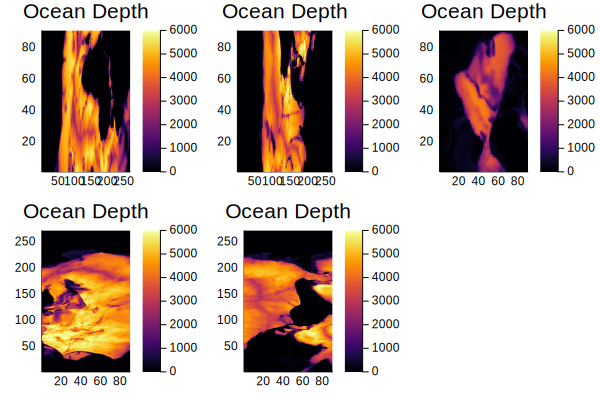

In [3]:
p=dirname(pathof(MeshArrays))
include(joinpath(p,"../examples/Plots.jl"))
heatmap(D,title="Ocean Depth",clims=(0.,6000.))

## A `MeshArray` Behaves Like A `Array`

Here are a few examples that would be coded similarly in both cases

In [4]:
size(D)
eltype(D)
view(D,:)

D .* 1.0
D .* D
1000*D
D*1000

D[findall(D .> 300.)] .= NaN
D[findall(D .< 1.)] .= NaN

D[1]=0.0 .+ D[1]
tmp=cos.(D);

## Let's switch grid now

In [5]:
pth="../inputs/GRID_CS32/"
γ=GridSpec("LatLonCap",pth)

http="https://github.com/gaelforget/GRID_CS32"
!isdir(pth) ? run(`git clone $http $pth`) : nothing

γ=GridSpec("CubeSphere",pth)
D=γ.read(γ.path*"Depth.data",MeshArray(γ,Float32))
show(D)

 gcmarray 
  grid type   = CubeSphere
  data type   = Float32
  tile array  = (6,)
  tile sizes  = (32, 32)
                (32, 32)
                (32, 32)
                (32, 32)
                (32, 32)
                (32, 32)


## The `exchange` Function

It adds neighboring points at face edges to slightly extend the computational domain as often needed e.g. to compute partial derivatives.

In [6]:
Dexch=exchange(D,4)
show(Dexch)

 gcmarray 
  grid type   = CubeSphere
  data type   = Float32
  tile array  = (6,)
  tile sizes  = (40, 40)
                (40, 40)
                (40, 40)
                (40, 40)
                (40, 40)
                (40, 40)


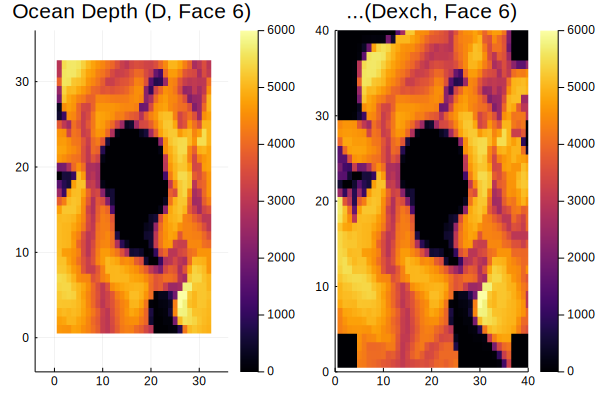

In [7]:
P=heatmap(D.f[6],title="Ocean Depth (D, Face 6)",lims=(-4,36))
Pexch=heatmap(Dexch.f[6],title="...(Dexch, Face 6)",lims=(0,40))
plot(P,Pexch)

# Diffusion-Based Smoothing

The unit testing of `MeshArrays.jl` uses the `smooth()` function. Starting from a random noise field, the smoothing efficiency is predictable and can be set via a smoothing scale parameter [(see Weaver and Courtier, 2001)](https://doi.org/10.1002/qj.49712757518).

This example also illustrates the generality of the `MeshArrays` approach, where the same code in `demo2` is readily applicable to any `PeriodicDomain`, `PeriodicChanel`, `CubeSphere`, or `LatLonCap` grid. Here the chosen grid maps onto the `6` faces of a cube with `16*16` points per face, with distances, areas, etc all set to `1.0`.

In [8]:
p=dirname(pathof(MeshArrays))
include(joinpath(p,"../examples/Demos.jl"))
γ,Γ=GridOfOnes("CubeSphere",6,16)
Δ=demo2(Γ);

The initial noise field is `D[1]` while the smoothed one is `D[2]`. After `smooth()` has been applied via `demo2()`, the noise field is visibly smoother and more muted.

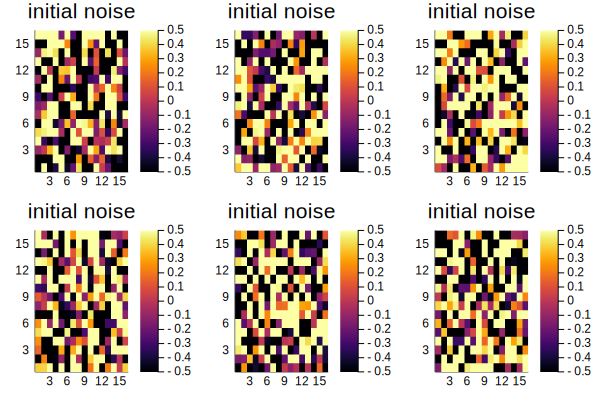

In [9]:
heatmap(Δ[1],title="initial noise",clims=(-0.5,0.5))

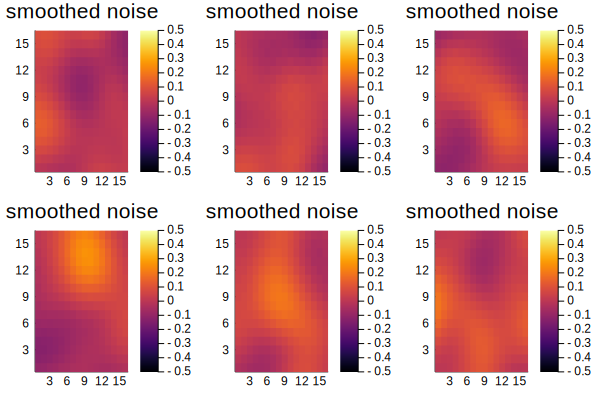

In [10]:
heatmap(Δ[2],title="smoothed noise",clims=(-0.5,0.5))

The computational cost of `smooth()` predictably  increases with the decorrelation scale. For more about how this works, please refer to **Weaver and Courtier, 2001** _Correlation modelling on the sphere using a generalized diffusion equation_ https://doi.org/10.1002/qj.49712757518

In [11]:
Rini=Δ[1]
DXCsm=Δ[3]
DYCsm=Δ[4]
@time Rend=smooth(Rini,DXCsm,DYCsm,Γ);
@time Rend=smooth(Rini,2DXCsm,2DYCsm,Γ);

  0.002352 seconds (8.21 k allocations: 6.800 MiB)
  0.019771 seconds (30.69 k allocations: 24.282 MiB, 45.72% gc time)
